Initialisation stage

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from datetime import timedelta, date

We read a weekly file from the MTA website to determine its structure

In [51]:
dateparse = lambda dates: [time.strptime(d, '%m/%d/%Y') for d in dates]

mta_test = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190202.txt", parse_dates=['DATE'])

##mta_test = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190202.txt")

In [52]:
mta_test.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,03:00:00,REGULAR,6922652,2347673
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,07:00:00,REGULAR,6922669,2347688
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,11:00:00,REGULAR,6922747,2347773
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,15:00:00,RECOVR AUD,6922932,2347849
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,19:00:00,REGULAR,6923237,2347911


The 'ENTRIES' column name is dirty!

In [53]:
mta_test.columns.values

array(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE',
       'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype=object)

Rename the column

In [54]:
mta_test.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [55]:
mta_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202912 entries, 0 to 202911
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   C/A       202912 non-null  object        
 1   UNIT      202912 non-null  object        
 2   SCP       202912 non-null  object        
 3   STATION   202912 non-null  object        
 4   LINENAME  202912 non-null  object        
 5   DIVISION  202912 non-null  object        
 6   DATE      202912 non-null  datetime64[ns]
 7   TIME      202912 non-null  object        
 8   DESC      202912 non-null  object        
 9   ENTRIES   202912 non-null  int64         
 10  EXITS     202912 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 17.0+ MB


We found that the DESC column has a small amout of 'RECOVR AUD', which we learned refers to audits updated 

In [27]:
mta_test['DESC'].value_counts()

REGULAR       201952
RECOVR AUD       960
Name: DESC, dtype: int64

The names of stations are not in a consistant format

In [29]:
mta_test['STATION'].value_counts().head(20)

34 ST-PENN STA     4195
FULTON ST          4016
23 ST              3081
GRD CNTRL-42 ST    2955
CANAL ST           2476
86 ST              2467
34 ST-HERALD SQ    2295
CHAMBERS ST        2266
59 ST              2149
42 ST-PORT AUTH    2142
WALL ST            2135
TIMES SQ-42 ST     2134
ATL AV-BARCLAY     2032
125 ST             1810
PATH NEW WTC       1774
59 ST COLUMBUS     1722
14 ST              1690
28 ST              1654
14 ST-UNION SQ     1638
CORTLANDT ST       1625
Name: STATION, dtype: int64

In [102]:
mta_test['TIME'].value_counts()

03:00:00    17249
07:00:00    17243
19:00:00    17221
15:00:00    17217
23:00:00    17213
            ...  
03:00:49        1
14:53:19        1
22:39:55        1
14:37:53        1
03:56:43        1
Name: TIME, Length: 12614, dtype: int64

Grouping by Station, C/A, unit, SCP (and optionally date), and then taking the difference between max and min of entry and exit counters

In [65]:

(mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min())

STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    2753
                                 2019-01-27    2070
                                 2019-01-28    3842
                                 2019-01-29    4201
                                 2019-01-30    4274
                                               ... 
ZEREGA AV  R419  R326  00-05-01  2019-01-28       0
                                 2019-01-29       0
                                 2019-01-30       0
                                 2019-01-31       0
                                 2019-02-01       0
Name: ENTRIES, Length: 33631, dtype: int64

In [ ]:
mta_test['EXITS']

In [57]:
## gets the number of entries and exits
mta_entries = mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min()

mta_exits = mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.min()


This is what the grouped data looks like before flattening

In [58]:
print(mta_entries)
print(mta_exits)

STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    2753
                                 2019-01-27    2070
                                 2019-01-28    3842
                                 2019-01-29    4201
                                 2019-01-30    4274
                                               ... 
ZEREGA AV  R419  R326  00-05-01  2019-01-28       0
                                 2019-01-29       0
                                 2019-01-30       0
                                 2019-01-31       0
                                 2019-02-01       0
Name: ENTRIES, Length: 33631, dtype: int64
STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    3718
                                 2019-01-27    3120
                                 2019-01-28    3597
                                 2019-01-29    3831
                                 2019-01-30    3534
                                     

Flatten and merge the entry and exit datasets

In [117]:
mta_entries_flat = mta_entries.reset_index()
mta_exits_flat = mta_exits.reset_index()

mta_entries_exits = pd.merge(mta_entries_flat, mta_exits_flat, how='outer')
print(mta_entries_exits)

STATION   C/A  UNIT       SCP       DATE  ENTRIES  EXITS
0           1 AV  H007  R248  00-00-00 2019-01-26     2753   3718
1           1 AV  H007  R248  00-00-00 2019-01-27     2070   3120
2           1 AV  H007  R248  00-00-00 2019-01-28     3842   3597
3           1 AV  H007  R248  00-00-00 2019-01-29     4201   3831
4           1 AV  H007  R248  00-00-00 2019-01-30     4274   3534
...          ...   ...   ...       ...        ...      ...    ...
33626  ZEREGA AV  R419  R326  00-05-01 2019-01-28        0      0
33627  ZEREGA AV  R419  R326  00-05-01 2019-01-29        0      0
33628  ZEREGA AV  R419  R326  00-05-01 2019-01-30        0      0
33629  ZEREGA AV  R419  R326  00-05-01 2019-01-31        0      0
33630  ZEREGA AV  R419  R326  00-05-01 2019-02-01        0      0

[33631 rows x 7 columns]


Append weekday column to dataset

In [121]:
mta_entries_exits['WEEKDAY'] = mta_entries_exits['DATE'].dt.day_name()

In [133]:
mta_bystation

,STATION,DATE,WEEKDAY,ENTRIES,EXITS
0,1 AV,2019-01-26,Saturday,15001,18465
1,1 AV,2019-01-27,Sunday,11887,14116
2,1 AV,2019-01-28,Monday,18617,21205
3,1 AV,2019-01-29,Tuesday,19714,23064
4,1 AV,2019-01-30,Wednesday,19708,22868
...,...,...,...,...,...
2637,ZEREGA AV,2019-01-28,Monday,2637,2074
2638,ZEREGA AV,2019-01-29,Tuesday,2754,2298
2639,ZEREGA AV,2019-01-30,Wednesday,2715,2248
2640,ZEREGA AV,2019-01-31,Thursday,2207,1836


Group by station and date (including weekday) and flatten the resultant dataset

In [132]:
mta_bystation = mta_entries_exits.groupby(['STATION','DATE','WEEKDAY']).sum().reset_index()

In [181]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"]

,STATION,DATE,WEEKDAY,ENTRIES,EXITS
427,34 ST-PENN STA,2019-01-26,Saturday,77849,75662
428,34 ST-PENN STA,2019-01-27,Sunday,66531,63272
429,34 ST-PENN STA,2019-01-28,Monday,161183,145887
430,34 ST-PENN STA,2019-01-29,Tuesday,169162,155165
431,34 ST-PENN STA,2019-01-30,Wednesday,165812,153787
432,34 ST-PENN STA,2019-01-31,Thursday,157907,143326
433,34 ST-PENN STA,2019-02-01,Friday,157598,148396


In [123]:
weekday_dict = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

Plot the traffic for top 5 stations; weekends are highlighted 

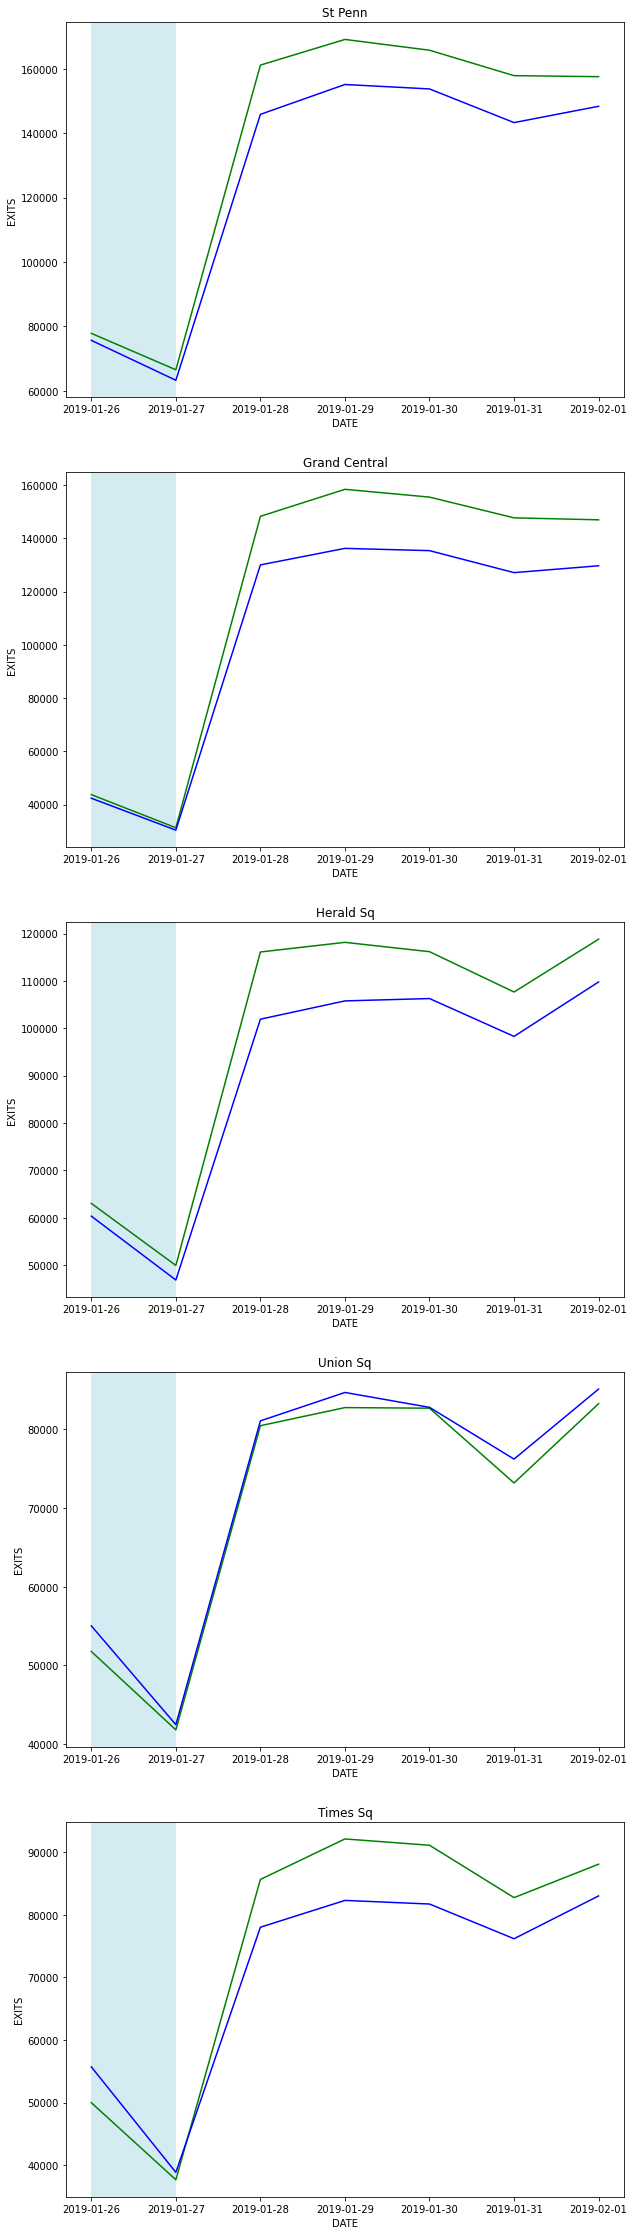

In [223]:
fig, axs = plt.subplots(nrows=5, figsize=(10,40))

def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

def highlight_datetimes(indices, ax, data):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(data.at[data.index[indices[i]], 'DATE'], data.at[data.index[indices[i] + 1], 'DATE'], facecolor='lightblue', edgecolor='none', alpha=.5)
        i += 1

mta = {}
plot_num = 0

mta['stpenn'] = [mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"], 'St Penn']
mta['grdcntrl'] = [mta_bystation[mta_bystation.STATION == "GRD CNTRL-42 ST"], 'Grand Central']
mta['heraldsq'] = [mta_bystation[mta_bystation.STATION == "34 ST-HERALD SQ"], 'Herald Sq']
mta['unionsq'] = [mta_bystation[mta_bystation.STATION == "14 ST-UNION SQ"], 'Union Sq']
mta['timessq'] = [mta_bystation[mta_bystation.STATION == "TIMES SQ-42 ST"], 'Times Sq']

for station in mta:

    sns.lineplot(data = mta[station][0], x='DATE', y='ENTRIES', color='green', ax=axs[plot_num]).set_title(mta[station][1])
    sns.lineplot(data = mta[station][0], x='DATE', y='EXITS', color='blue', ax=axs[plot_num]);
    weekend_indices = find_weekend_indices(mta[station][0].DATE.tolist())
    highlight_datetimes(weekend_indices, axs[plot_num], mta[station][0])
    plot_num += 1



In [202]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"].at[427, 'DATE']

Timestamp('2019-01-26 00:00:00')

In [205]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"].index[0]

427

In [55]:
mta_stations = pd.read_excel("http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls")

In [56]:
mta_stations.head()

,Remote,Booth,Station,Line Name,Division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT
2,R001,R101S,SOUTH FERRY,R1,IRT
3,R002,A077,FULTON ST,ACJZ2345,BMT
4,R002,A081,FULTON ST,ACJZ2345,BMT


### TODO:

- transit data from Feb 2 to Mar 29 2019
    - MVP: week ending Feb 2 2019
- header file for stations/booths (filtering by station)
    - MVP: top 5 stations
- focus on data between 8 am and 8 pm
    - MVP: focus on day (24 hour period)

### Immeadiate tasks:

- combine turnstile and station data
- plot data (day vs vol of passanger)


- combine data from different weeks
- filter/group data by station
- columns: stations, station exits, day of week, number of exits, number of entrances
- determine the difference between REGULAR and RECOVER AUD in DESC column ->> RECOVER AUD adds recovered data after the fact
- group traffic data by stations, see trends on weekdays vs weekends


In [45]:
mta_station_geoloc = pd.read_json("https://data.ny.gov/resource/i9wp-a4ja.json")

In [46]:
mta_station_geoloc.head()

,division,line,station_name,station_latitude,station_longitude,route1,entrance_type,entry,vending,staffing,...,route4,route5,route6,route7,route8,route9,ada_notes,staff_hours,route10,route11
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
mta_exits_geoloc = pd.read_csv("https://raw.githubusercontent.com/chriswhong/nycturnstiles/master/geocoded.csv", header=None, names=['Remote','Booth', 'Station Name', 'Station ID', 'Division', 'Latitute', 'Longitude'])

In [48]:
mta_exits_geoloc.head()

,Remote,Booth,Station Name,Station ID,Division,Latitute,Longitude
0,R470,X002,ELTINGVILLE PK,Z,SRT,40.544600,-74.164581
1,R544,PTH02,HARRISON,1,PTH,40.738879,-74.155533
2,R165,S102,TOMPKINSVILLE,1,SRT,40.636948,-74.074824
3,R070,S101,ST. GEORGE,1,SRT,40.643738,-74.073622
4,R070,S101A,ST. GEORGE,1,SRT,40.643738,-74.073622


In [91]:
pd.read_csv?

Signature:
pd.read_csv(
    filepath_or_buffer:Union[str, pathlib.Path, IO[~AnyStr]],
    sep=',',
    delimiter=None,
    header='infer',
    names=None,
    index_col=None,
    usecols=None,
    squeeze=False,
    prefix=None,
    mangle_dupe_cols=True,
    dtype=None,
    engine=None,
    converters=None,
    true_values=None,
    false_values=None,
    skipinitialspace=False,
    skiprows=None,
    skipfooter=0,
    nrows=None,
    na_values=None,
    keep_default_na=True,
    na_filter=True,
    verbose=False,
    skip_blank_lines=True,
    parse_dates=False,
    infer_datetime_format=False,
    keep_date_col=False,
    date_parser=None,
    dayfirst=False,
    cache_dates=True,
    iterator=False,
    chunksize=None,
    compression='infer',
    thousands=None,
    decimal:str='.',
    lineterminator=None,
    quotechar='"',
    quoting=0,
    doublequote=True,
    escapechar=None,
    comment=None,
    encoding=None,
    dialect=None,
    error_bad_lines=True,
    warn_bad_lines